# OFDM Symbol Builder (Static Version)

This notebook demonstrates how Orthogonal Frequency Division Multiplexing (OFDM) symbols are generated at the PHY layer.
We walk through the steps of:
1. Generating random user data (bits)
2. Mapping those bits to modulation symbols (BPSK, QPSK, 16QAM)
3. Allocating symbols into an OFDM subcarrier grid
4. Applying the IFFT to create time-domain OFDM symbols
5. Adding Cyclic Prefix (CP)
6. (Optional) Simulating MIMO with two antennas
7. Plotting all major stages


## 1. Set Simulation Parameters

In [1]:
# You can adjust these parameters before re-running the notebook
num_bits = 64  # Number of random bits to transmit
fft_size = 64  # Number of subcarriers (FFT points)
cp_length = 16  # Cyclic prefix length (samples)
mod_type = 'QPSK'  # Choose from: 'BPSK', 'QPSK', '16QAM'
num_symbols = 2  # How many OFDM symbols to generate
mimo = False  # If True, generate MIMO (2 streams)

## 2. Import Libraries and Setup Plotting

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import ifft

## 3. Bit-to-Symbol Mapping (Modulation)

In [3]:
def modulate(bits, mod_type='QPSK'):
    """Map bits to complex symbols depending on modulation type."""
    if mod_type == 'BPSK':
        return (1 - 2*np.array(bits)) + 0j
    elif mod_type == 'QPSK':
        symbols = []
        for i in range(0, len(bits), 2):
            b0, b1 = bits[i], bits[i+1]
            symbol = (1 - 2*b0) + 1j*(1 - 2*b1)
            symbols.append(symbol / np.sqrt(2))  # Normalized energy
        return np.array(symbols)
    elif mod_type == '16QAM':
        mapping = {
            (0,0,0,0): -3-3j, (0,0,0,1): -3-1j, (0,0,1,0): -3+3j, (0,0,1,1): -3+1j,
            (0,1,0,0): -1-3j, (0,1,0,1): -1-1j, (0,1,1,0): -1+3j, (0,1,1,1): -1+1j,
            (1,0,0,0):  3-3j, (1,0,0,1):  3-1j, (1,0,1,0):  3+3j, (1,0,1,1):  3+1j,
            (1,1,0,0):  1-3j, (1,1,0,1):  1-1j, (1,1,1,0):  1+3j, (1,1,1,1):  1+1j,
        }
        symbols = []
        for i in range(0, len(bits), 4):
            group = tuple(bits[i:i+4])
            symbol = mapping.get(group, 0)
            symbols.append(symbol / np.sqrt(10))  # Normalize avg power
        return np.array(symbols)
    else:
        raise ValueError("Unsupported modulation type")

## 4. OFDM Symbol Generation and Visualization

In [4]:
# Step-by-step OFDM generation and visualization

# Step 1: Generate random bits
bits = np.random.randint(0, 2, num_bits)

# Step 2: Map bits to modulation symbols
symbols = modulate(bits, mod_type)

# Step 3: Allocate symbols to subcarriers
max_symbols = min(len(symbols), fft_size)
symbols = symbols[:max_symbols]

# Step 4: Apply IFFT and add cyclic prefix
tx_stream = []
for _ in range(num_symbols):
    grid = np.zeros(fft_size, dtype=complex)
    start = fft_size // 2 - max_symbols // 2
    grid[start:start + max_symbols] = symbols
    ofdm = ifft(grid)
    with_cp = np.concatenate([ofdm[-cp_length:], ofdm])
    tx_stream.extend(with_cp)

# Step 5 (Optional): Simulate MIMO with 2 antennas
if mimo:
    tx_stream = np.stack([
        tx_stream,
        tx_stream + np.random.normal(0, 0.05, len(tx_stream))  # Add slight variation
    ])

## 5. Visualize Each Stage

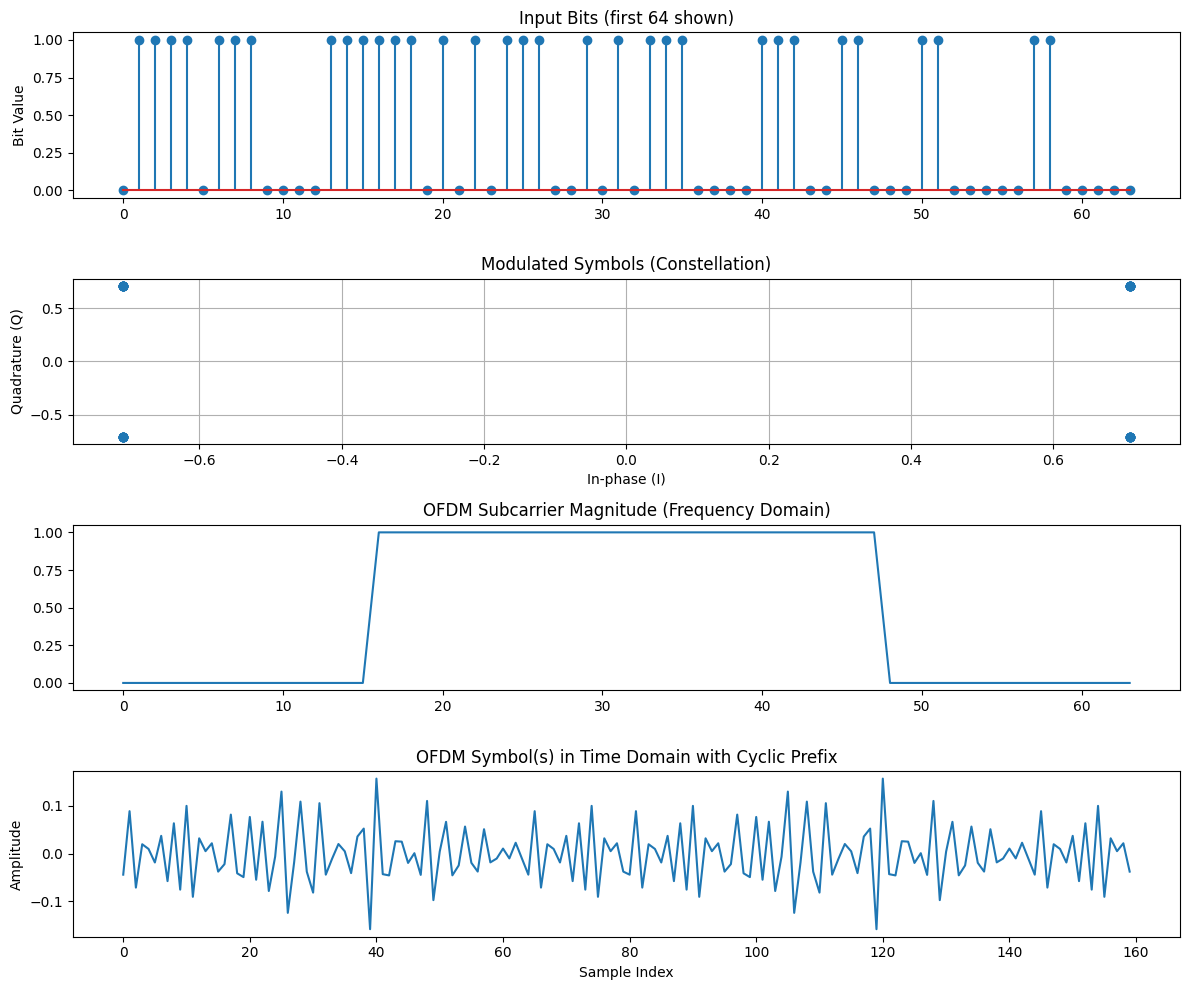

In [5]:
fig, axs = plt.subplots(4, 1, figsize=(12, 10))

# Plot raw bits
axs[0].stem(bits[:64])
axs[0].set_title("Input Bits (first 64 shown)")
axs[0].set_ylabel("Bit Value")

# Plot I/Q constellation
axs[1].plot(np.real(symbols), np.imag(symbols), 'o')
axs[1].set_title("Modulated Symbols (Constellation)")
axs[1].set_xlabel("In-phase (I)")
axs[1].set_ylabel("Quadrature (Q)")
axs[1].grid(True)

# Plot subcarrier magnitude
axs[2].plot(np.abs(grid))
axs[2].set_title("OFDM Subcarrier Magnitude (Frequency Domain)")

# Plot time-domain OFDM symbol(s)
if mimo:
    axs[3].plot(np.real(tx_stream[0]), label='Antenna 1')
    axs[3].plot(np.real(tx_stream[1]), label='Antenna 2')
    axs[3].legend()
else:
    axs[3].plot(np.real(tx_stream))
axs[3].set_title("OFDM Symbol(s) in Time Domain with Cyclic Prefix")
axs[3].set_xlabel("Sample Index")
axs[3].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()